In [1]:
import os, glob, time
import numpy as np
from numpy.lib.stride_tricks import as_strided
from proc_utils import *

from gwdatafind import find_urls
#import gwpy as gwpy
from gwpy.io.gwf import get_channel_names
from gwpy.timeseries import TimeSeries
from gwpy.signal import filter_design
#import pycbc as pycbc
from pycbc import frame
from pycbc.waveform import get_td_waveform
from pycbc.detector import Detector

import pyarrow.parquet as pq
import pyarrow as pa

import matplotlib.pyplot as plt
# Not the same module the TimeSeries.Plot() calls, unfortunately
#plt.rcParams['pdf.fonttype'] = 42
#plt.rcParams['mathtext.fontset'] = 'cm'
%matplotlib inline

In [2]:
###################################################################
# Processing params
t_window  = 6#6 #16 #12 # s
t_stride  = 0.5#1 #4 #12 # s
fcalib_lo = 16. # Hz
fsg_lo    = 35.
fsg_hi    = 250.
whiten_fft = (4, 2) # s (fft length, stride) in s
inj_sg = True
#inj_sg = False
print('>> Making waveforms...')
print('.. window length: %d s'%t_window)
print('.. stride length: %d s'%t_stride)
print('.. highpass preselection: f > %d Hz'%fcalib_lo)
print('.. whitening FFT (window, stride):',whiten_fft, 's')
print('.. bandpass selection: %d < f < %d Hz'%(fsg_lo, fsg_hi))
print('.. inject signal? %s'%str(inj_sg))

>> Making waveforms...
.. window length: 6 s
.. stride length: 0 s
.. highpass preselection: f > 16 Hz
.. whitening FFT (window, stride): (4, 2) s
.. bandpass selection: 35 < f < 250 Hz
.. inject signal? True


In [3]:
kH1, kL1 = 'H1', 'L1'
ks = [kH1, kL1]
inputfiles = {}
for k in ks:
    print('.. detector:',k)
    inputfiles[k] = open('data/O1/gwf/O1_%s_local_idx004_list.txt'%k).readlines()[1:2]
    inputfiles[k] = [f.strip() for f in inputfiles[k]]
    print(len(inputfiles[k]))
    for f in inputfiles[k]:
        print('..',f)
        assert os.path.exists(f)
    
seed_from_file = int(inputfiles[k][0].split('-')[-2])
print('.. rand seed to be used:',seed_from_file)

.. detector: H1
1
.. /export/home/phys/mbandrews/work/gw/data/O1/gwf/H-H1_LOSC_4_V1-1126555648-4096.gwf
.. detector: L1
1
.. /export/home/phys/mbandrews/work/gw/data/O1/gwf/L-L1_LOSC_4_V1-1126555648-4096.gwf
.. rand seed to be used: 1126555648


In [4]:
###################################################################
# Check input file channels
kdq, kinj, kdata = {}, {}, {}

for k in ks:
    kdq[k], kinj[k], kdata[k] = get_channel_names(inputfiles[k][0])
    print(kdq[k], kinj[k], kdata[k])
    print('>> Available channels:')
    print('.. strain data :',kdata[k])
    print('.. data quality:',kdq[k])
    print('.. hardware inj:',kinj[k])

H1:LOSC-DQMASK H1:LOSC-INJMASK H1:LOSC-STRAIN
>> Available channels:
.. strain data : H1:LOSC-STRAIN
.. data quality: H1:LOSC-DQMASK
.. hardware inj: H1:LOSC-INJMASK
L1:LOSC-DQMASK L1:LOSC-INJMASK L1:LOSC-STRAIN
>> Available channels:
.. strain data : L1:LOSC-STRAIN
.. data quality: L1:LOSC-DQMASK
.. hardware inj: L1:LOSC-INJMASK


In [5]:
###################################################################
# Read in gwf frames
series, series_dq, series_inj = {}, {}, {}
print('>> Reading frames...')
for k in ks:
    series[k] = TimeSeries.read(inputfiles[k], kdata[k])#, start=start, end=end)
    series_dq[k] = TimeSeries.read(inputfiles[k], kdq[k])#, start=start, end=end)
    series_inj[k] = TimeSeries.read(inputfiles[k], kinj[k])#, start=start, end=end)

    print(series[k])
    print('.. sample_rate:',series[k].sample_rate)
    
    # Timestamps should be same for H1 and L1 file, so only need to store
    # value from one of them
    if k != 'H1': continue

    # see: https://gwpy.github.io/docs/stable/api/gwpy.timeseries.TimeSeries.html#gwpy.timeseries.TimeSeries
    t0 = series[k].t0.value
    dt = series[k].dt.value
    t_total = series[k].duration.value
    tf = t0 + t_total
    print('.. [t0, tf): [%f, %f) s'%(t0, tf))
    print('.. duration: %f s'%t_total)
    print('.. dt: %f s'%dt)
    print('.. len(series):',len(series[k]))
    #assert t_total == end-start
    assert len(series[k]) == series[k].duration.value/series[k].dt.value

    times = series[k].times.value
    print('.. GPS times:',series[k].times)
    print('.. time span:',series[k].xspan)
    print('.. times[ 0]:',series[k].times[0])
    print('.. times[-1]:',series[k].times[-1])
    print('.. len(times):',len(times))
    assert len(series[k]) == len(times)

# Verify timestamps are indeed identical
assert t0 == series[kL1].t0.value
assert dt == series[kL1].dt.value
assert t_total == series[kL1].duration.value
assert np.array_equal(times, series[kL1].times.value)

>> Reading frames...
TimeSeries([6.09857293e-19, 5.34426124e-19, 5.46468684e-19, ...,
            1.52980890e-19, 1.84861617e-19, 1.82384122e-19]
           unit: dimensionless,
           t0: 1126555648.0 s,
           dt: 0.000244140625 s,
           name: H1:LOSC-STRAIN,
           channel: H1:LOSC-STRAIN)
.. sample_rate: 4096.0 Hz
.. [t0, tf): [1126555648.000000, 1126559744.000000) s
.. duration: 4096.000000 s
.. dt: 0.000244 s
.. len(series): 16777216
.. GPS times: [1.12655565e+09 1.12655565e+09 1.12655565e+09 ... 1.12655974e+09
 1.12655974e+09 1.12655974e+09] s
.. time span: [1126555648.0 ... 1126559744.0)
.. times[ 0]: 1126555648.0 s
.. times[-1]: 1126559743.9997559 s
.. len(times): 16777216
TimeSeries([-1.92454075e-19, -2.24493831e-19, -2.84756886e-19,
            ..., -2.16390949e-18, -2.09516760e-18,
            -2.03694360e-18]
           unit: dimensionless,
           t0: 1126555648.0 s,
           dt: 0.000244140625 s,
           name: L1:LOSC-STRAIN,
           channel: 

In [6]:
###################################################################
# Initialize pq output params
print('>> Initializing output...')
outname = inputfiles[kH1][0].split('/')[-1].split('.')[0]
outname = '%s_%s'%('-'.join(ks), '_'.join(outname.split('_')[1:]))
pqout = '%s_%s.parquet'%(outname, 'sgbg' if inj_sg else 'bg')
print('.. parquet output:',pqout)

>> Initializing output...
.. parquet output: H1-L1_LOSC_4_V1-1126555648-4096_sgbg.parquet


In [9]:
###################################################################
# Set segment params
# For this job, set random seed based on first input file GPS time
np.random.seed(seed_from_file)
#from numpy.random import MT19937
#from numpy.random import RandomState, SeedSequence
#rs = RandomState(MT19937(SeedSequence(seed_from_file)))
print(np.random.randint(10, size=5))
print(np.random.randint(10, size=5))

# Choose a GPS end time, sky location, and polarization phase for the merger
# NOTE: Right ascension and polarization phase runs from 0 to 2pi
#       Declination runs from pi/2. to -pi/2 with the poles at pi/2. and -pi/2.
# See known events: https://www.gw-openscience.org/eventapi/html/allevents/
#
print('>> Making time segments via striding...')

window = int(t_window//dt) # steps
stride = int(t_stride//dt) # steps
assert t_window <= t_total
assert t_window >= t_stride
print('.. len(window):', window)
print('.. len(stride):', stride)

# Get stride params
byte_strides = (times.strides[0]*stride, times.strides[0])
nsegs = (len(times)-window)/stride + 1
print('.. N segments:', nsegs)
if nsegs%1 != 0:
    print(nsegs)
    print('!! WARNING: series will be truncated!')
nsegs = int(np.floor(nsegs))
print('.. N segments:', nsegs)

# Do actual strides to make time segments
timesegs = as_strided(times, shape=(nsegs, window), strides=byte_strides)
print('.. timesegs[ 0][ 0]: %f s'%timesegs[0][0])
print('.. timesegs[-1][-1]: %f s'%timesegs[-1][-1])
assert nsegs == len(timesegs)

# Calculate effective windows
t_trunc   = 2.5 #2. # s: how much to truncate at start and end of series after whitening, to remove artifacts
n_trunc   = int(t_trunc//dt) # N elements in t_trunc
t_eff     = t_window - 2*(t_trunc)
print('.. amount to truncate on either side of waveform, after whitening: %2.1f s (%d elements)'%(t_trunc, n_trunc))
print('.. effective waveform window per time segment: %d s (%d elements)'%(t_eff, t_eff//dt))

###################################################################
# Set BBH sim params
inj_sg = True #False
if inj_sg:
    # Make uniform distn
    # [a, b) ~ (b-a)*np.random.random(size) + a

    # Time placement of GW signal
    # defines *end time* of GW signal
    t_pad_lo   = 0.2#0.25 # s how near to left end of t_eff to place signal
    t_pad_hi   = 0.05#0.   # s how near to right end of t_eff to place signal
    t_gwoff_lo = t_trunc+t_eff-t_pad_lo+dt
    t_gwoff_hi = t_trunc+t_pad_hi+dt
    print(t_gwoff_lo, t_gwoff_hi)
    # offset to apply from end time of noise waveform
    #t_gwoffs   = (t_gwoff_hi-t_gwoff_lo)*np.random.random(nsegs) + t_gwoff_lo #-24 # end of GW
    t_gwoffs   = (t_gwoff_hi-t_gwoff_lo)*np.array([0.]) + t_gwoff_lo #-24 # end of GW
    #print(t_gwoff_lo, t_gwoff_hi, t_gwoffs[-5:])

    # BBH phase space
    mlo, mhi = 5., 6.
    dlo, dhi = 100., 101.
    m1s   = (mhi-mlo)*np.random.random(nsegs) + mlo    # in M_sun. GW150914: ~35M_sun. [10, 100] -> [10, 50]
    m2s   = (mhi-mlo)*np.random.random(nsegs) + mlo    # in M_sun. GW150914: ~30M_sun. [10, 100] -> [10, 50]
    sp1s  = 0.99*np.random.random(nsegs)    # spinz1 (0., 0.99)
    sp2s  = 0.99*np.random.random(nsegs)    # spinz1 (0., 0.99)
    incs  = np.array([0.]) #np.pi*np.random.random(nsegs)   # 0. # right ascension: [0, pi]
    dists = (dhi-dlo)*np.random.random(nsegs) + dlo    # 340Mpc, distance to detector, in Mpc, [1e2, 5e3], Andromeda galaxy about ~< 1 Mpc away from Earth.
    decs  = 2*np.pi*np.random.random(nsegs) - np.pi/2. #0.65 # declination: [-pi/2, pi/2)
    ras   = 2*np.pi*np.random.random(nsegs)            #0. # right ascension: [0, 2pi]
    pols  = 2*np.pi*np.random.random(nsegs) - np.pi/2. #0. # polarization: [-pi, pi) or [0, 2pi] (controls phase of wave)

[1 9 2 1 9]
[4 0 4 7 5]
>> Making time segments via striding...
.. len(window): 24576
.. len(stride): 2048
.. N segments: 8181.0
.. N segments: 8181
.. timesegs[ 0][ 0]: 1126555648.000000 s
.. timesegs[-1][-1]: 1126559743.999756 s
.. amount to truncate on either side of waveform, after whitening: 2.5 s (10240 elements)
.. effective waveform window per time segment: 1 s (4096 elements)
3.300244140625 2.550244140625


>> Looping over time segments...
.. 0 / 8181
   .. m1:5.168924, m2:5.215890, sp1:0.463827, sp2:0.537913, inc:0.000000, coa:0.000000, dist:100.737315, dec:4.648913, ra:5.545414, pol:2.895120, t_end:1126555650.699756


'FreeSans.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


   .. GW, max strain: 8.327352192483165e-22
   .. whitened series duration: 1.0 s


'FreeSans.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


   .. m1:5.168924, m2:5.215890, sp1:0.463827, sp2:0.537913, inc:0.000000, coa:0.000000, dist:100.737315, dec:4.648913, ra:5.545414, pol:2.895120, t_end:1126555650.699756


'FreeSans.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


   .. GW, max strain: 6.353771816581986e-22
   .. whitened series duration: 1.0 s


'FreeSans.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


4096 1.0
>> Done.
.. nwrite / nsegs: 1 / 8181
.. processing time: 8.219362 s


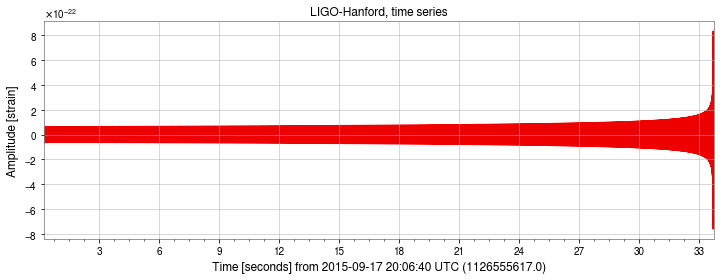

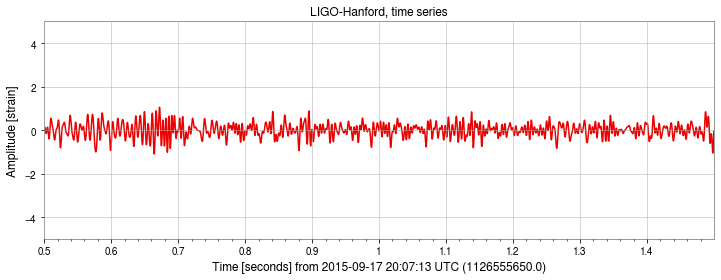

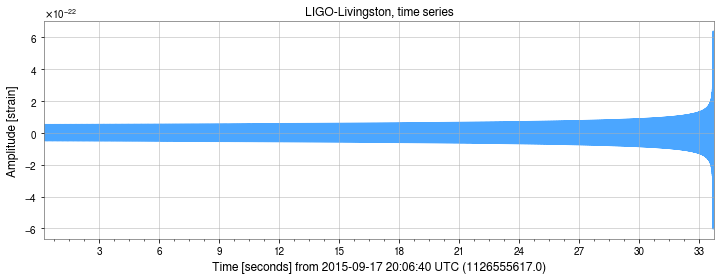

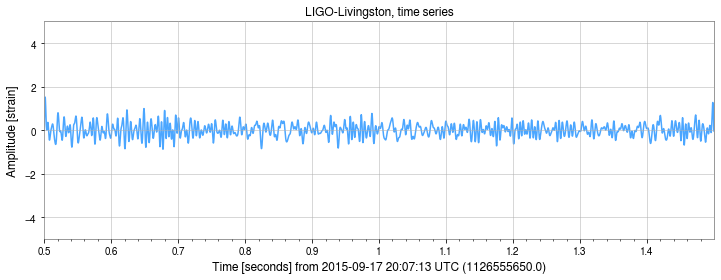

In [10]:
###################################################################
# Make time segments
print('>> Looping over time segments...')

nprint = 2  # Frequency of debug prints
nwrite = 0   # N segments actually written out after quality cuts

# dicts for holding batches of each detector
batch, dqs, injs = {}, {}, {}
sg, sb, wav = {}, {}, {}

# dict for holding output values to parquet
data = {}

now = time.time()
for i in range(nsegs):
    
    if i%nprint == 0: print('.. %d / %d'%(i, nsegs))
    if i>2:
        pass
        break

    # Get time window for this segment
    tseg = timesegs[i]
    tstart, tend = tseg[0], tseg[-1]+dt # stride generates [t0, t1), so need to add +dt to get full t_window
    assert t_window == tend-tstart
    
    skip_batch = False
    # Get data for this segment
    for k in ks:
        batch[k] = series[k].crop(tstart, tend)
        dqs[k]   = series_dq[k].crop(tstart, tend)
        injs[k]  = series_inj[k].crop(tstart, tend)
        assert batch[k].duration.value == t_window
        #print(batch[0], batch[1], batch[2], batch[3])

        # Quality cuts
        # NOTE: only needs to be checked for effective window
        # i.e. full window less truncated segments
        # Make sure no NaNs
        if np.any(np.isnan(batch[k].value[n_trunc:-n_trunc])):
            skip_batch = True
        # Make sure DQ:CAT3 for both CBC and burst
        if np.any(dqs[k].value[n_trunc:-n_trunc] != 127):
            skip_batch = True
        # Make sure there were no hardware injs
        if np.any(injs[k].value[n_trunc:-n_trunc] != 31):
            skip_batch = True
    
    if skip_batch: continue

    assert np.array_equal(batch[kH1].times.value, batch[kL1].times.value)
    debug = True #if i%nprint == 0 else False
    
    # Waveform processing
    if inj_sg:
        for k in ks:
            det = detstr(k)
            # Generate GW signal
            saveplot = '%s-%s_sg_seg%05d.pdf'%(outname, det, i)
            #sg[k] = make_bbh(m1s[i], m2s[i], dists[i], decs[i], ras[i], pols[i], tend-t_gwoffs[i], fcalib_lo, dt, debug=debug, saveplot=saveplot, kdet=k)
            sg[k] = make_bbh_spin(m1s[i], m2s[i], sp1s[i], sp2s[i], incs[i], 0., dists[i], decs[i], ras[i], pols[i], tend-t_gwoffs[i], fcalib_lo, dt, debug=debug, saveplot=saveplot, kdet=k)
            # Inject signal into data
            sb[k] = batch[k].inject(sg[k])
            # Process waveform
            saveplot = '%s-%s_sgbg_seg%05d.pdf'%(outname, det, i)
            wav[k] = process_strain(sb[k], w=whiten_fft, fcalib_lo=fcalib_lo, fsg_lo=fsg_lo, fsg_hi=fsg_hi, t_trunc=t_trunc, dt=dt, debug=debug, saveplot=saveplot, det=det)
    else:
        for k in ks:
            det = detstr(k)
            # Process waveform
            saveplot = '%s-%s_bg_seg%05d.pdf'%(outname, det, i)
            wav[k] = process_strain(batch[k], w=whiten_fft, fcalib_lo=fcalib_lo, fsg_lo=fsg_lo, fsg_hi=fsg_hi, t_trunc=t_trunc, dt=dt, debug=debug, saveplot=saveplot, det=det)

    print(len(wav[kH1]), wav[kH1].duration.value)
    skip_batch = False
    for k in ks:
        if np.any(np.isnan(wav[k].value)):
            skip_batch = True

    if skip_batch: continue

    #print(wav[kH1].value.shape, wav[kL1].value.shape)
    #wav_ = np.stack([wav[kH1].value, wav[kH1].value], axis=0)
    #print(wav_.shape)
    #break
    #'''
    # Write to parquet
    # First, convert to dict
    data['strain'] = np.stack([wav[kH1].value, wav[kL1].value], axis=0)
    data['t0']     = wav[kH1].times.value[0]
    data['y']      = 1. if inj_sg else 0.
    data['m1']     = m1s[i]
    data['m2']     = m2s[i]
    data['sp1']    = sp1s[i]
    data['sp2']    = sp2s[i]
    data['inc']    = incs[i]
    data['dist']   = dists[i]
    data['dec']    = decs[i]
    data['ra']     = ras[i]
    data['pol']    = pols[i]
    data['toff']   = t_eff-t_gwoffs[i] # store offset from start time of this waveform instead
    # Then convert to pq arrays
    pqdata = [pa_array(d) for d in data.values()]
    # Then convert to pq table
    table = pa.Table.from_arrays(pqdata, list(data.keys()))
    # Write table to pq file
    #if nwrite == 0:
    #    writer = pq.ParquetWriter(pqout, table.schema, compression='snappy')
    #writer.write_table(table)
    #'''
    nwrite += 1
    break

#writer.close()
proc_time = time.time() - now
print('>> Done.')
#print('deltat:',deltats[1]-deltats[0])
print('.. nwrite / nsegs: %d / %d'%(nwrite, nsegs))
print('.. processing time: %s'%('%f s'%proc_time if proc_time <= 60 else '%f min'%proc_time/60.))

In [41]:
print(batch[kL1].value)
print(batch[kL1].value.shape)
print(batch[kL1].value[n_trunc:-n_trunc].shape)
print(batch[kL1].value[n_trunc:-n_trunc])
print(np.any(np.isnan(batch[k].value[n_trunc:-n_trunc])))

[-1.92454075e-19 -2.24493831e-19 -2.84756886e-19 ...
 -1.48784071e-19 -1.43420188e-19 -2.03223578e-19]
(24576,)
(4096,)
[-2.00517768e-18 -1.98722671e-18 -2.05832320e-18 ...
 -1.24431690e-18 -1.24553201e-18 -1.27349177e-18]
False


In [35]:
# Do a read test
pqin = pq.ParquetFile(pqout)
print(pqin.metadata)
print(pqin.schema)
X = pqin.read_row_group(0, columns=['t0','y','m1','m2','strain']).to_pydict()
print(X['t0'], X['y'], X['m1'], X['m2'])
strain_ = np.float32(X['strain'])
print(strain_.shape)

  created_by: parquet-cpp-arrow version 5.0.0
  num_columns: 10
  num_rows: 3
  num_row_groups: 3
  format_version: 1.0
  serialized_size: 3679
required group field_id=-1 schema {
  optional group field_id=-1 strain (List) {
    repeated group field_id=-1 list {
      optional group field_id=-1 item (List) {
        repeated group field_id=-1 list {
          optional float field_id=-1 item;
        }
      }
    }
  }
  optional float field_id=-1 t0;
  optional float field_id=-1 y;
  optional float field_id=-1 m1;
  optional float field_id=-1 m2;
  optional float field_id=-1 dist;
  optional float field_id=-1 dec;
  optional float field_id=-1 ra;
  optional float field_id=-1 pol;
  optional float field_id=-1 toff;
}

[1126555648.0] [1.0] [41.853729248046875] [47.498619079589844]
(1, 2, 8192)
